In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pytz

# Exploração e Tratamento dos dados

In [2]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc
0,2019-04-14,02:29:00,2019-04-14,02:30:00,Ida,100,271,00:01:00,0,0.000
1,2019-04-14,03:30:00,2019-04-14,03:30:00,Ida,100,271,00:00:00,0,0.000
2,2019-04-13,01:28:00,2019-04-13,01:28:00,Ida,100,276,00:00:00,0,0.000
3,2019-04-12,03:28:00,2019-04-12,03:28:00,Ida,100,279,00:00:00,0,0.000
4,2019-04-07,00:31:00,2019-04-07,00:31:00,Ida,100,273,00:00:00,0,0.000
...,...,...,...,...,...,...,...,...,...,...
2694355,2019-10-01,04:00:00,2019-10-01,04:34:00,Volta,477,50404,00:34:00,5,17.294
2694356,2019-10-01,04:29:00,2019-10-01,05:12:00,Volta,477,50359,00:43:00,7,17.294
2694357,2019-10-01,05:15:00,2019-10-01,05:47:00,Volta,477,50404,00:32:00,7,17.294
2694358,2019-10-01,05:47:00,2019-10-01,05:47:00,Volta,477,50404,00:00:00,0,17.294


In [3]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [4]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [5]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [6]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [7]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
0,Ida,100,60,0,0.000,2019-04-14 02:29:00,2019-04-14 02:30:00
1,Ida,100,0,0,0.000,2019-04-14 03:30:00,2019-04-14 03:30:00
2,Ida,100,0,0,0.000,2019-04-13 01:28:00,2019-04-13 01:28:00
3,Ida,100,0,0,0.000,2019-04-12 03:28:00,2019-04-12 03:28:00
4,Ida,100,0,0,0.000,2019-04-07 00:31:00,2019-04-07 00:31:00
...,...,...,...,...,...,...,...
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00
2694358,Volta,477,0,0,17.294,2019-10-01 05:47:00,2019-10-01 05:47:00


In [8]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [9]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\629631639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Km/H', inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00
...,...,...,...,...,...,...,...
2694352,Volta,477,1500,1,17.294,2019-10-01 03:30:00,2019-10-01 03:55:00
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00


In [10]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3472968728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia_semana'] = df['Ini'].dt.dayofweek + 1
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3472968728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hora_dia'] = df['Ini'].dt.hour
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3472968728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [11]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [12]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [13]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

,Linha,media,desvio
0,100,30.416667,0.900337
34,164,30.416667,0.900337
35,165,30.416667,0.900337
37,168,30.416667,0.900337
77,270,30.416667,0.900337
...,...,...,...
8,1120,26.166667,2.124889
10,1122,26.333333,2.188122
9,1121,26.333333,2.188122
134,601V,20.000000,3.567530


In [14]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

,Linha,mes_ano,dias,contagem
1608,601V,1,"[31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...",22
1609,601V,2,"[59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...",20
1610,601V,3,"[88, 87, 86, 85, 84, 67, 66, 65, 63, 60]",10
1611,601V,4,"[120, 119, 116, 115, 114, 113, 112, 108, 107, ...",21
1612,601V,5,"[151, 150, 149, 148, 147, 144, 143, 142, 141, ...",22
1613,601V,6,"[179, 178, 177, 176, 175, 172, 170, 169, 168, ...",18
1614,601V,7,"[212, 211, 210, 207, 206, 205, 204, 203, 200, ...",23
1615,601V,8,"[242, 241, 240, 239, 238, 235, 234, 233, 232, ...",22
1616,601V,9,"[273, 270, 269, 268, 267, 266, 263, 262, 261, ...",21
1617,601V,10,"[304, 303, 302, 301, 298, 297, 296, 295, 294, ...",23


In [15]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


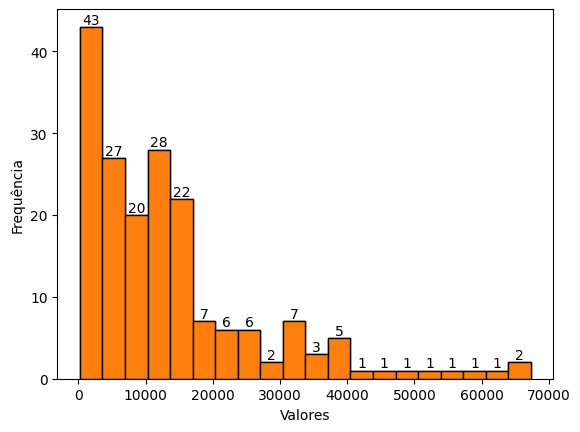

In [16]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Valores')  # Rótulo do eixo x
plt.ylabel('Frequência')  # Rótulo do eixo y
# Exibir o histograma
plt.show()

In [17]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
179,Volta,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
180,Volta,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
181,Volta,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
182,Volta,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
183,Volta,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [18]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido,Ida,Volta,Diferenca
Linha,,,
138,0,16346,-16346
136,0,16296,-16296
137,0,15949,-15949
135,0,15936,-15936
772,0,10950,-10950
...,...,...,...
274,2790,2202,588
281,8657,7953,704
330V,6235,5511,724


In [19]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [20]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

,Linha,TotalGiros
2,110,0.003722
58,362,4.119939
40,180,4.325447
38,178,5.977037
91,943,6.096262
...,...,...
17,136,44.577320
54,294,46.153422
19,138,48.245626
16,135,50.508471


In [21]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
1164,0,110,1140,0,7.629,2019-04-30 08:34:00,2019-04-30 08:53:00,2,8,120,4,2
1165,0,110,1200,0,7.629,2019-04-30 12:25:00,2019-04-30 12:45:00,2,12,120,4,2
1166,0,110,1500,0,7.629,2019-04-30 13:02:00,2019-04-30 13:27:00,2,13,120,4,2
1167,0,110,1500,0,7.629,2019-04-30 13:40:00,2019-04-30 14:05:00,2,13,120,4,2
1168,0,110,1680,0,7.629,2019-04-30 14:23:00,2019-04-30 14:51:00,2,14,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2475219,1,110,780,0,7.713,2019-09-02 18:10:00,2019-09-02 18:23:00,1,18,245,9,4
2475220,1,110,1800,0,7.713,2019-09-02 18:11:00,2019-09-02 18:41:00,1,18,245,9,4
2475221,1,110,720,0,7.713,2019-09-02 18:46:00,2019-09-02 18:58:00,1,18,245,9,4
2475222,1,110,840,0,7.713,2019-09-02 19:06:00,2019-09-02 19:20:00,1,19,245,9,4


In [22]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
179,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
180,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
181,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
182,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
183,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,1,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,1,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,1,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,1,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


   Linha  DuraçãoViagem
83   769     299.285125
25   162     307.003065
51   282     308.414705
57   362     320.880172
45   263     322.334440
..   ...            ...
15   135     969.436064
16   136    1033.633614
18   138    1056.295415
41  2120    1126.105276
85   840    1149.508023

[94 rows x 2 columns]


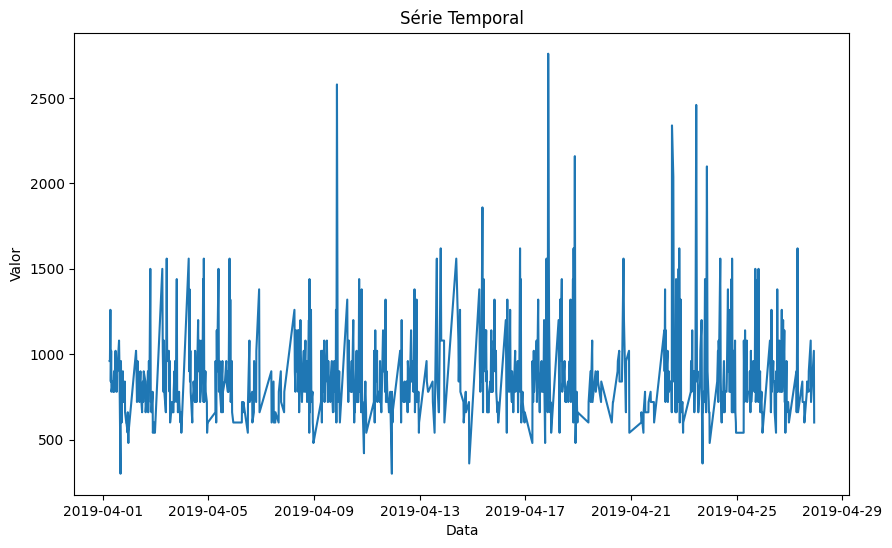

In [23]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [24]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
928051,1,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
928052,1,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
928053,1,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
928054,1,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


   Linha  DuraçãoViagem
0    362     180.525409
1    271     200.506881
2    169     205.213838
3    162     211.636999
4    168     211.744094
..   ...            ...
89   136     782.542959
90   135     793.372851
91   138     823.866071
92   235     842.370148
93  4122     862.373308

[94 rows x 2 columns]


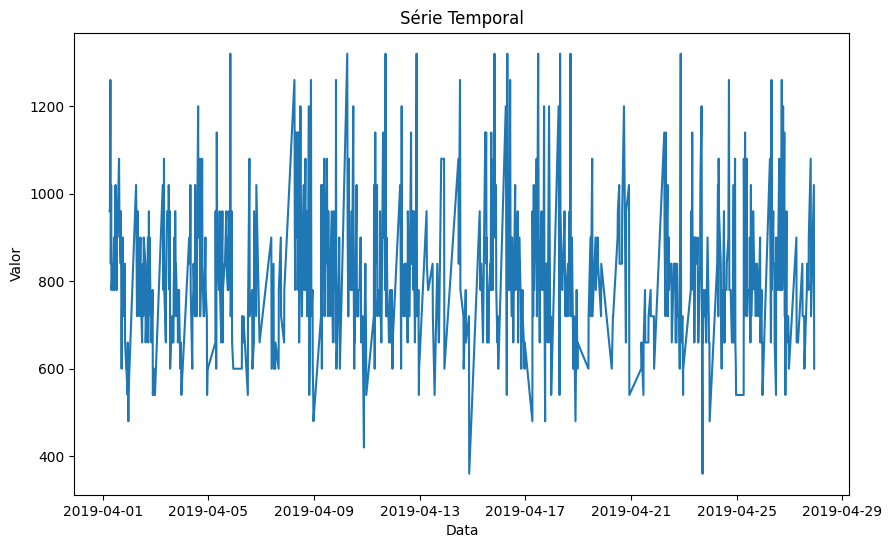

In [25]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [26]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

,Linha,DuraçãoViagem
0,362,180.525409
1,271,200.506881
64,605,497.489081
65,1120,521.072152
92,235,842.370148
93,4122,862.373308


In [27]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
33734,0,1120,3600,22,31.218,2018-11-01 06:10:00,2018-11-01 07:10:00,4,6,305,11,2
33735,0,1120,4800,32,31.218,2018-11-01 06:43:00,2018-11-01 08:03:00,4,6,305,11,2
33951,1,1120,3300,2,30.640,2018-11-01 07:14:00,2018-11-01 08:09:00,4,7,305,11,2
33952,1,1120,3480,1,30.640,2018-11-01 08:08:00,2018-11-01 09:06:00,4,8,305,11,2
33736,0,1120,4800,30,31.218,2018-11-01 08:09:00,2018-11-01 09:29:00,4,8,305,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...
40794,0,605,3360,7,19.437,2019-10-31 14:58:00,2019-10-31 15:54:00,4,14,304,10,2
40795,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2
40796,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2
40797,0,605,4380,24,19.437,2019-10-31 18:02:00,2019-10-31 19:15:00,4,18,304,10,4


In [28]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

,KmPerc,Sentido
Linha,,
1120,31.218,5609
235,24.110,6047
271,13.903,14393
362,4.240,9768
4122,25.244,5301
605,19.437,3729


In [29]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [30]:
predictions = []
metrics = []
def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor(
        # gamma = 0.0,
        # learning_rate = 0.01,
        # max_depth = 4,
        # min_child_weight = 8,
        # n_estimators = 500
    )
    modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor(
        # bootstrap = True,
        # max_depth = 11,
        # max_features = 'log2',
        # min_samples_leaf = 7,
        # min_samples_split = 6,
        # n_estimators = 500
    )
    modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RRSE_xgb = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeXGB}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RRSE_rf = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeRF}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RRSE_lr = np.sqrt(sum((df_teste["DuraçãoViagem"] - df_teste[f"{TesteNomeLR}"]) ** 2) / sum((df_teste["DuraçãoViagem"] - np.mean(df_teste["DuraçãoViagem"])) ** 2))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RRSE',RRSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RRSE',RRSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RRSE',RRSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])

    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb.sort_values("importance").plot(kind="barh", title=f"Importância Dados XGB {rota}")
    #plt.savefig(f"Images/FI_XGB_{rota}_{teste_nome}.jpg")

    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf.sort_values("importance").plot(kind="barh", title=f"Importância Dados RF {rota}")
    #plt.savefig(f"Images/FI_RF_{rota}_{teste_nome}.jpg")

### Execuções por rotas

[0]	validation_0-rmse:2745.87974
[1]	validation_0-rmse:1943.53296
[2]	validation_0-rmse:1387.68833
[3]	validation_0-rmse:1006.32581
[4]	validation_0-rmse:749.10335
[5]	validation_0-rmse:579.66931
[6]	validation_0-rmse:471.83577
[7]	validation_0-rmse:405.94169
[8]	validation_0-rmse:365.43787
[9]	validation_0-rmse:340.96364
[10]	validation_0-rmse:328.39240
[11]	validation_0-rmse:319.71708
[12]	validation_0-rmse:313.83635
[13]	validation_0-rmse:310.34462
[14]	validation_0-rmse:306.70710
[15]	validation_0-rmse:302.01084
[16]	validation_0-rmse:298.16911
[17]	validation_0-rmse:294.36644
[18]	validation_0-rmse:292.67155
[19]	validation_0-rmse:290.05872
[20]	validation_0-rmse:286.71065
[21]	validation_0-rmse:285.51248
[22]	validation_0-rmse:281.77675
[23]	validation_0-rmse:280.64581
[24]	validation_0-rmse:277.51919
[25]	validation_0-rmse:276.03233
[26]	validation_0-rmse:273.09035
[27]	validation_0-rmse:269.98771
[28]	validation_0-rmse:267.70848
[29]	validation_0-rmse:266.01499
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1927.11408
[1]	validation_0-rmse:1375.36832
[2]	validation_0-rmse:996.46082
[3]	validation_0-rmse:739.34327
[4]	validation_0-rmse:568.17531
[5]	validation_0-rmse:457.78233
[6]	validation_0-rmse:386.72801
[7]	validation_0-rmse:345.35359
[8]	validation_0-rmse:320.83808
[9]	validation_0-rmse:305.68421
[10]	validation_0-rmse:293.04832
[11]	validation_0-rmse:286.51042
[12]	validation_0-rmse:280.44759
[13]	validation_0-rmse:274.88960
[14]	validation_0-rmse:272.02213
[15]	validation_0-rmse:267.92702
[16]	validation_0-rmse:266.39593
[17]	validation_0-rmse:264.12645
[18]	validation_0-rmse:262.89972
[19]	validation_0-rmse:258.01553
[20]	validation_0-rmse:252.22449
[21]	validation_0-rmse:249.23973
[22]	validation_0-rmse:248.07140
[23]	validation_0-rmse:246.24790
[24]	validation_0-rmse:242.27031
[25]	validation_0-rmse:238.95944
[26]	validation_0-rmse:238.02140
[27]	validation_0-rmse:235.72666
[28]	validation_0-rmse:233.59254
[29]	validation_0-rmse:231.73019
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.08266
[1]	validation_0-rmse:719.22435
[2]	validation_0-rmse:516.90274
[3]	validation_0-rmse:379.62333
[4]	validation_0-rmse:289.02635
[5]	validation_0-rmse:231.30885
[6]	validation_0-rmse:195.66208
[7]	validation_0-rmse:175.69191
[8]	validation_0-rmse:163.22036
[9]	validation_0-rmse:156.29512
[10]	validation_0-rmse:153.06444
[11]	validation_0-rmse:150.61432
[12]	validation_0-rmse:149.06689
[13]	validation_0-rmse:148.21234
[14]	validation_0-rmse:145.66986
[15]	validation_0-rmse:143.51304
[16]	validation_0-rmse:142.62120
[17]	validation_0-rmse:142.18939
[18]	validation_0-rmse:141.30512
[19]	validation_0-rmse:140.50743
[20]	validation_0-rmse:140.22681
[21]	validation_0-rmse:139.41017
[22]	validation_0-rmse:138.29394
[23]	validation_0-rmse:137.37022
[24]	validation_0-rmse:136.75849
[25]	validation_0-rmse:136.11486
[26]	validation_0-rmse:135.63785
[27]	validation_0-rmse:135.44947
[28]	validation_0-rmse:134.76133
[29]	validation_0-rmse:133.83752
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:601.38111
[1]	validation_0-rmse:435.42730
[2]	validation_0-rmse:323.37999
[3]	validation_0-rmse:249.57293
[4]	validation_0-rmse:203.04141
[5]	validation_0-rmse:175.53953
[6]	validation_0-rmse:159.30246
[7]	validation_0-rmse:150.02434
[8]	validation_0-rmse:144.06254
[9]	validation_0-rmse:140.73732
[10]	validation_0-rmse:138.79877
[11]	validation_0-rmse:136.94832
[12]	validation_0-rmse:135.74492
[13]	validation_0-rmse:135.23831
[14]	validation_0-rmse:134.21688
[15]	validation_0-rmse:133.85238
[16]	validation_0-rmse:133.28242
[17]	validation_0-rmse:132.25349
[18]	validation_0-rmse:131.97162
[19]	validation_0-rmse:131.05125
[20]	validation_0-rmse:130.69286
[21]	validation_0-rmse:130.37471
[22]	validation_0-rmse:129.98270
[23]	validation_0-rmse:129.45398
[24]	validation_0-rmse:128.43698
[25]	validation_0-rmse:128.07084
[26]	validation_0-rmse:127.26752
[27]	validation_0-rmse:126.83248
[28]	validation_0-rmse:126.07133
[29]	validation_0-rmse:125.41195
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2245.07952
[1]	validation_0-rmse:1608.08796
[2]	validation_0-rmse:1170.62354
[3]	validation_0-rmse:877.20704
[4]	validation_0-rmse:683.32980
[5]	validation_0-rmse:560.88281
[6]	validation_0-rmse:483.85816
[7]	validation_0-rmse:438.61740
[8]	validation_0-rmse:412.55460
[9]	validation_0-rmse:396.53711
[10]	validation_0-rmse:384.34483
[11]	validation_0-rmse:376.90725
[12]	validation_0-rmse:371.63830
[13]	validation_0-rmse:365.48042
[14]	validation_0-rmse:362.89756
[15]	validation_0-rmse:360.25896
[16]	validation_0-rmse:358.17593
[17]	validation_0-rmse:355.52269
[18]	validation_0-rmse:355.01230
[19]	validation_0-rmse:352.05102
[20]	validation_0-rmse:349.34086
[21]	validation_0-rmse:344.44638
[22]	validation_0-rmse:343.74656
[23]	validation_0-rmse:339.75001
[24]	validation_0-rmse:337.42050
[25]	validation_0-rmse:335.90747
[26]	validation_0-rmse:333.80990
[27]	validation_0-rmse:329.99765
[28]	validation_0-rmse:328.01426
[29]	validation_0-rmse:327.53065
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2330.94275
[1]	validation_0-rmse:1651.77786
[2]	validation_0-rmse:1182.30330
[3]	validation_0-rmse:860.35267
[4]	validation_0-rmse:643.20440
[5]	validation_0-rmse:499.97058
[6]	validation_0-rmse:409.82351
[7]	validation_0-rmse:353.77053
[8]	validation_0-rmse:318.74275
[9]	validation_0-rmse:297.19506
[10]	validation_0-rmse:285.73857
[11]	validation_0-rmse:277.50367
[12]	validation_0-rmse:272.72821
[13]	validation_0-rmse:267.50209
[14]	validation_0-rmse:264.42743
[15]	validation_0-rmse:262.70867
[16]	validation_0-rmse:258.48946
[17]	validation_0-rmse:257.55570
[18]	validation_0-rmse:253.76637
[19]	validation_0-rmse:250.27685
[20]	validation_0-rmse:247.45539
[21]	validation_0-rmse:245.94892
[22]	validation_0-rmse:242.76191
[23]	validation_0-rmse:240.14974
[24]	validation_0-rmse:239.54226
[25]	validation_0-rmse:238.70965
[26]	validation_0-rmse:236.93242
[27]	validation_0-rmse:235.02414
[28]	validation_0-rmse:231.55555
[29]	validation_0-rmse:229.77188
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_5028\3362685452.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

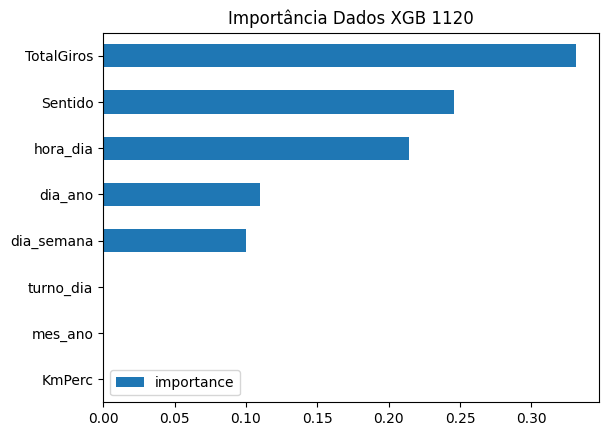

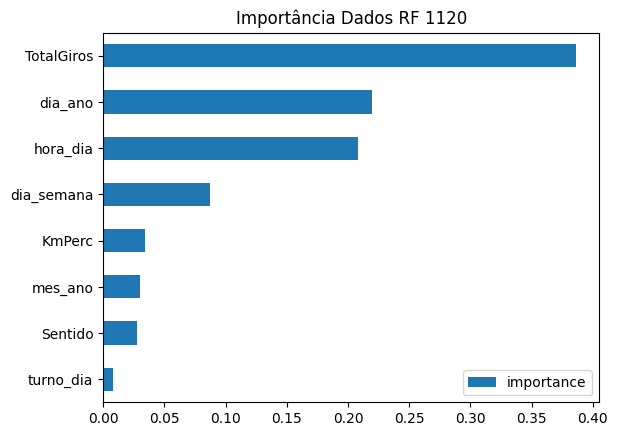

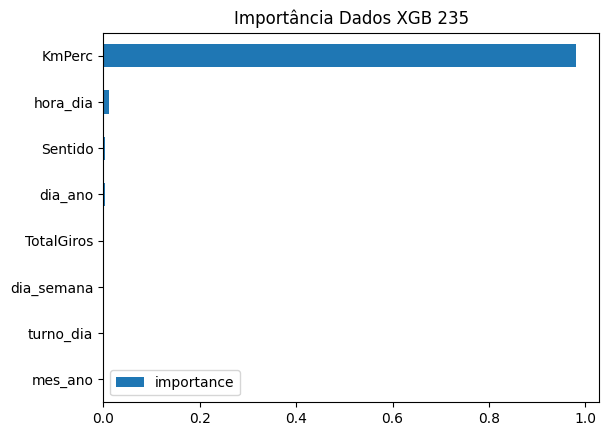

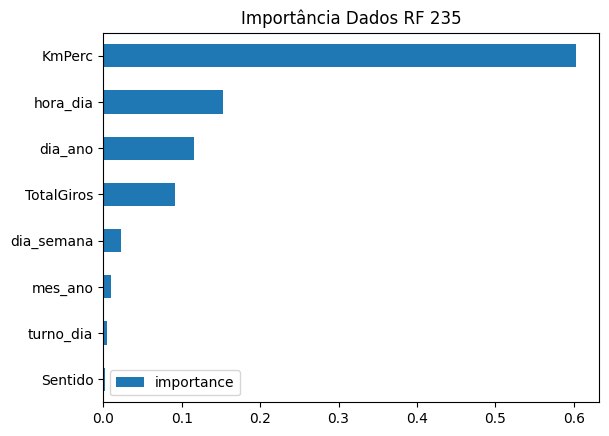

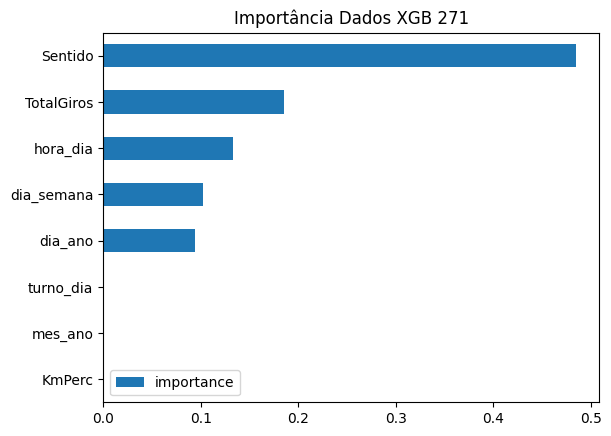

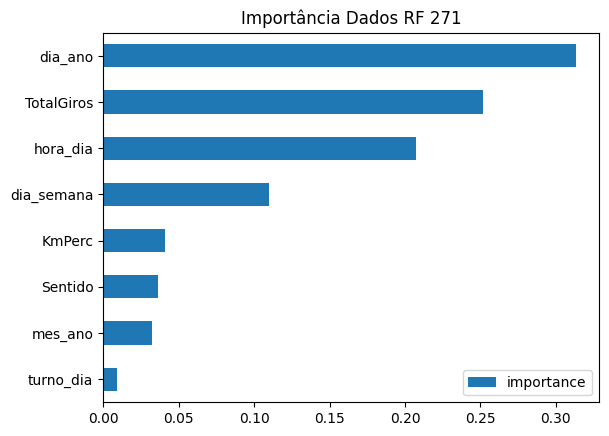

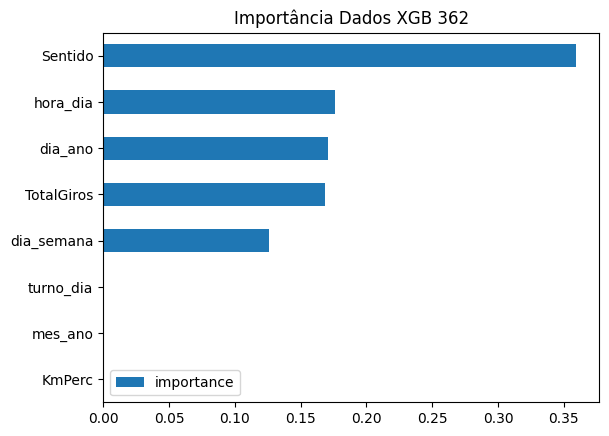

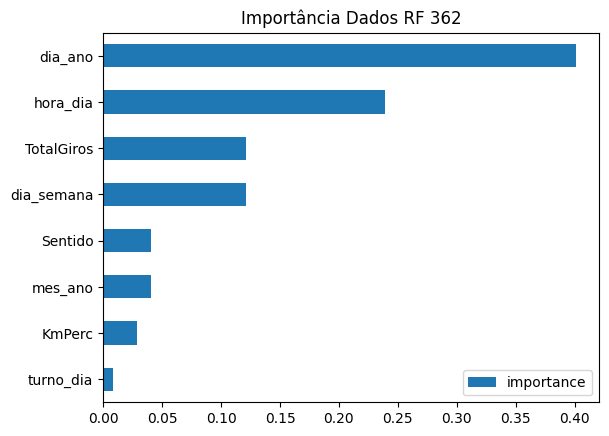

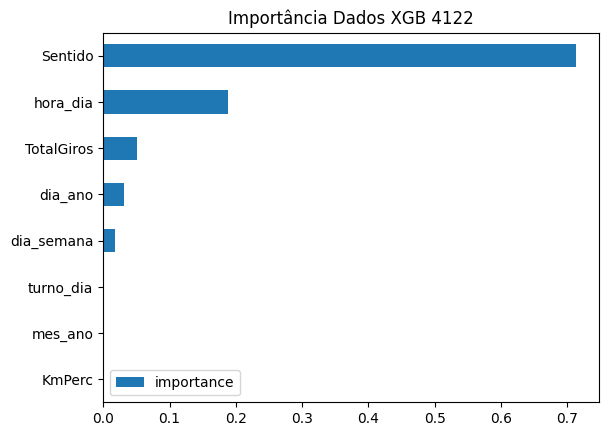

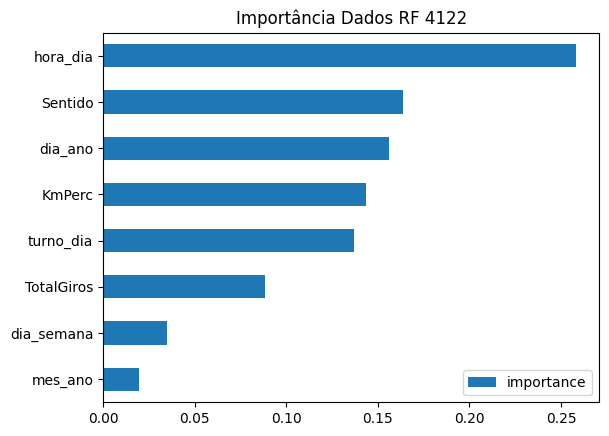

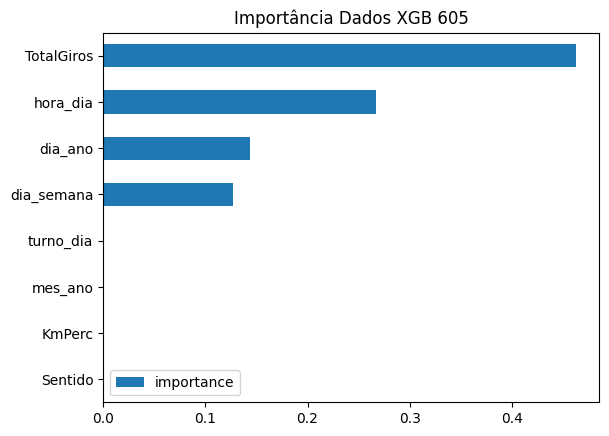

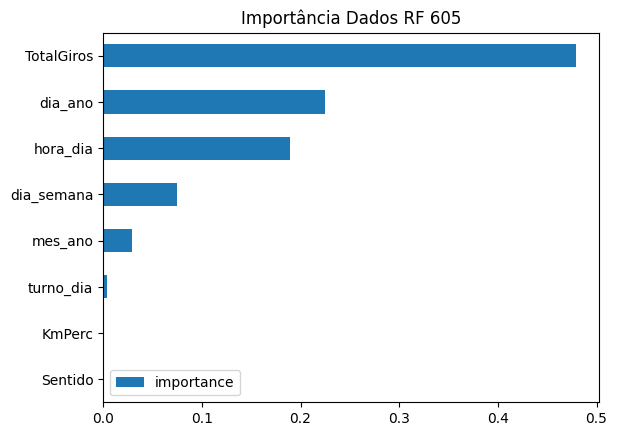

In [31]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)


In [32]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
10,"0 Teste de Colunas - ['Sentido','TotalGiros','...",235,Linear Regression,RRSE,0.465795,0.299900,0.20000
6,"0 Teste de Colunas - ['Sentido','TotalGiros','...",235,XGBoost,RRSE,0.467932,0.236509,0.39690
8,"0 Teste de Colunas - ['Sentido','TotalGiros','...",235,Random Forest,RRSE,0.476852,0.882622,0.32001
28,"0 Teste de Colunas - ['Sentido','TotalGiros','...",4122,Linear Regression,RRSE,0.626787,0.200100,0.20020
26,"0 Teste de Colunas - ['Sentido','TotalGiros','...",4122,Random Forest,RRSE,0.656269,0.737735,0.28998
0,"0 Teste de Colunas - ['Sentido','TotalGiros','...",1120,XGBoost,RRSE,0.713069,0.319995,0.39980
2,"0 Teste de Colunas - ['Sentido','TotalGiros','...",1120,Random Forest,RRSE,0.717079,0.807982,0.36093
24,"0 Teste de Colunas - ['Sentido','TotalGiros','...",4122,XGBoost,RRSE,0.727654,0.216515,0.40000
4,"0 Teste de Colunas - ['Sentido','TotalGiros','...",1120,Linear Regression,RRSE,0.776848,0.150000,0.19070
30,"0 Teste de Colunas - ['Sentido','TotalGiros','...",605,XGBoost,RRSE,0.858714,0.202997,0.30350


  Linha  DuraçãoViagem
0   362     180.525409
1   271     200.506881
2   605     497.489081
3  1120     521.072152
4   235     842.370148
5  4122     862.373308


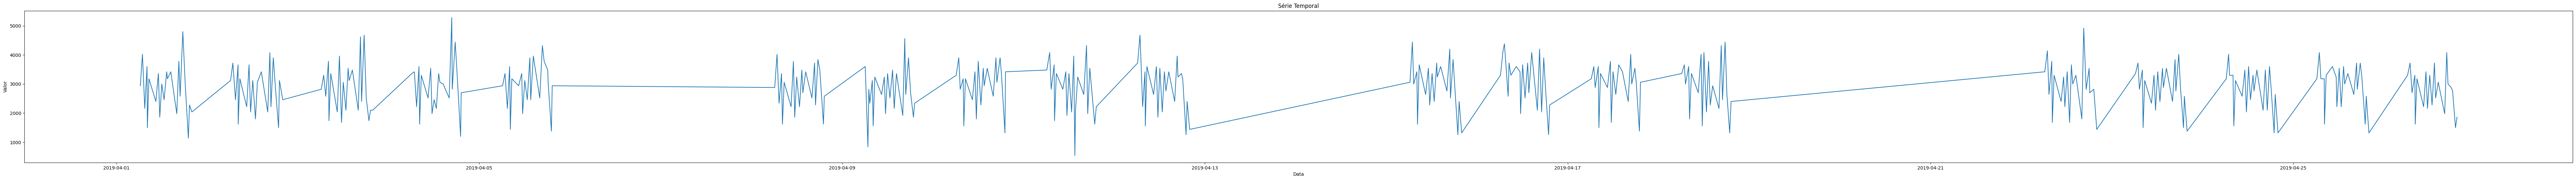

<Figure size 640x480 with 0 Axes>

In [38]:

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '4122'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(100, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()
plt.savefig(f"Images/rota_4122.jpg")

In [39]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

,Teste,Data,Rota,Modelo,Valor
0,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-10-31 19:44:00,1120,XGBoost,3774.097168
1,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-10-31 19:44:00,1120,Random Forest,3827.400000
2,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-10-31 19:44:00,1120,Linear Regression,4127.066903
3,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-10-31 19:44:00,1120,Tempo real,3600.000000
4,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-10-31 18:26:00,1120,XGBoost,4085.954102
...,...,...,...,...,...
53799,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-07-16 09:39:00,605,Tempo real,2640.000000
53800,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-07-16 08:37:00,605,XGBoost,3238.745850
53801,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-07-16 08:37:00,605,Random Forest,3358.200000
53802,"0 Teste de Colunas - ['Sentido','TotalGiros','...",2019-07-16 08:37:00,605,Linear Regression,3207.493110


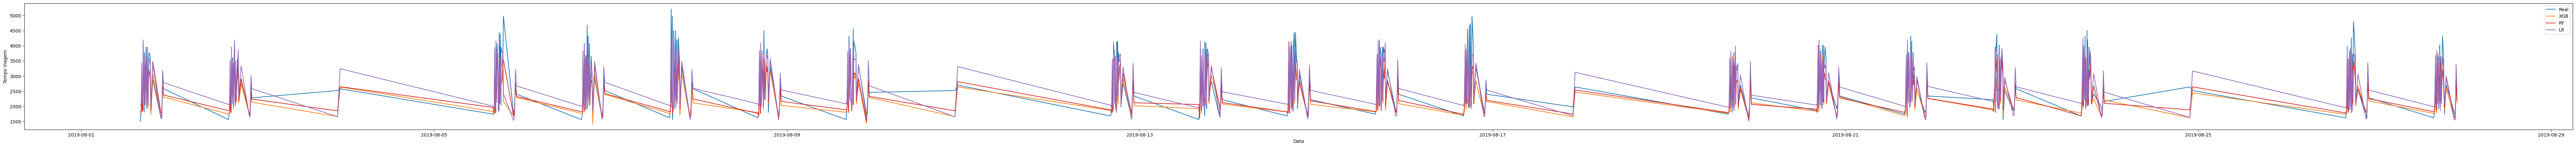

In [54]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(100, 5))

plt.xlabel("Data")
plt.ylabel("Tempo Viagem")

b = b.loc[(b["Data"] > "2019-08-01") & (b["Data"] < "2019-08-28") & (b['Rota'] == '235')]

real_plor = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plor["Data"], real_plor["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.legend()
plt.show()
#plt.savefig(f"Images/previsao_235.jpg")

In [ ]:
df.loc[df['Linha'] == '235']['KmPerc'].unique()

In [ ]:
df.corr()

In [ ]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['dia_semana','hora_dia','dia_ano'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['TotalGiros','dia_semana','hora_dia','dia_ano'],
    ['KmPerc','dia_semana','hora_dia','dia_ano'],
    ['TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano'],
    ['Sentido','TotalGiros','dia_semana','hora_dia','dia_ano']
]
TestesNome = [
    "1 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['TotalGiros','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano']",
    "1 Teste de Colunas - ['Sentido','TotalGiros','dia_semana','hora_dia','dia_ano']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

# Teste com clima

## Tratando dados de clima

In [ ]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

In [ ]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

In [ ]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

In [ ]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [ ]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Descricao Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [ ]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [ ]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"], axis=1, inplace=True)
clima.rename({"PRECIPITACAO TOTAL, HORARIO (mm)": "Precipitacao", "Temperatura Media": "Temperatura", "Descricao Chuva": "Chuva"}, axis=1, inplace=True)

In [ ]:
clima

In [ ]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df.dropna(subset=['Precipitacao','Temperatura'] ,inplace=True)
df

## Executando Testes

In [ ]:
df

In [ ]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao','Temperatura'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Temperatura'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva'],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao','Temperatura']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Precipitacao']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Temperatura']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva']",
    "2 - Teste clima - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Calor']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)


In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('asdf.xlsx')

# Testes tempos anteriores

In [ ]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

In [ ]:
Colunas = [
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('asdfg.xlsx')

# Teste com intervalor de treino diferentes

In [ ]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - Janeiro",
    "4 Teste de Intervalos - Março",
    "4 Teste de Intervalos - Maio",
    "4 Teste de Intervalos - Julho",
    "4 Teste de Intervalos - Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RRSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('cdsfg.xlsx')